In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import SimpleITK as sitk

import sys
np.set_printoptions(threshold=sys.maxsize)

## functions

In [2]:
## function definition

# function to convert DESI text file to numpy array
def DESI_txt2numpy(desi_text):
    """""
    input:
    desi_text - the location /name of the DESI text file
    output:
    peaks - 2D numpy array of DESI spectra with size [N_spectra x N_ions]
    mz - 1D numpy array of ions' m/z values [N_ions]
    dim_y - number of spectra in y axis
    dim_x - number of spectra in x axis
    (dim_y * dim_x = N_spectra)
    """""
    ##############################################
    # inner function for getting the number of spectra without buffering vthe data
    def num_lines_in_text(desi_text):

        # inner function for creating the generator
        def _count_generator(reader):
            b = reader(1024 * 1024)
            while b:
                yield b
                b = reader(1024 * 1024)
  
        with open(desi_text, 'rb') as read_obj:
            c_generator = _count_generator(read_obj.raw.read)
            # count each \n
            count = sum(buffer.count(b'\n') for buffer in c_generator)
            """Enters while loop, which continues as long as b (the chunk of data) is not empty. 
            This means that it will keep reading and yielding chunks of data until there's nothing left to read."""

        return count
    ##############################################
    
    print('file:', desi_text)

    total = num_lines_in_text(desi_text)
    print('spectra:', total-5)
    
    data = []
    with open(desi_text, 'r') as read_obj:
        for i,line in tqdm(enumerate(read_obj) , total=total):
            x = line.split()
            y = [float(num) for num in x]
            data.append(y)
            
    ind = np.argsort(data[3]) # data[3] has unsorted m/z values
    mz = np.take_along_axis(np.asarray(data[3]), ind, axis=0) # sort with indices

    x, y = [], []
    peaks = []
    for i in tqdm(range(4,len(data)-1)):
        x.append(data[i][1])
        y.append(data[i][2])
        p = np.asarray(data[i][3:-2])
        p = np.take_along_axis(p, ind, axis=0)
        p = np.expand_dims(p,axis=0)
        peaks.append(p)
    peaks = np.concatenate(peaks,axis=0)

    ## find desi data dimension
    t = np.asarray(x)
    t = np.abs(np.diff(t))
    dim_x = int(np.round(np.max(t)/np.min(t)))+1
    t = np.asarray(y)
    dim_y = int(np.round(np.abs(t[0]-t[-1])/np.max(np.abs(np.diff(t)))))+1
    print('image dimension:',dim_y, 'x', dim_x)
    
    return peaks, mz, dim_y, dim_x

# total ion current normalization (spectrum based)
def tic_normalize(peaks):
    tot_ion_cur = np.sum(peaks, axis=1)
    peaks_ticn = np.empty(peaks.shape)
    for i in range(len(peaks)):
        if tot_ion_cur[i]!=0:
            peaks_ticn[i] = peaks[i]/tot_ion_cur[i]
    return peaks_ticn

# normalize each ion in whole data to have min of 0 and max of 1 (ion based normalization)
def ion_minmax_normalize(peaks):
    max_ion_int = np.max(peaks, axis=0)
    min_ion_int = np.min(peaks, axis=0)
    peaks_ionorm = np.empty(peaks.shape)
    for i in range(peaks.shape[1]):
        if max_ion_int[i]!=min_ion_int[i]:
            peaks_ionorm[:,i] = (peaks[:,i]-min_ion_int[i])/(max_ion_int[i]-min_ion_int[i])
    return peaks_ionorm

## covert text DESI to numpy array

In [3]:
## read files, convert to matlab (or numpy), and save
data_path = r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata"
slide_name = r"2021 03 21 colon 0485699.txt"

file = os.path.join(data_path,slide_name)
[peaks, mz, dim_y, dim_x] = DESI_txt2numpy(file)

print(peaks.shape)
print(mz.shape)
print(dim_y, dim_x)

file: C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699.txt
spectra: 44178


  0%|          | 0/44183 [00:00<?, ?it/s]

  0%|          | 0/44178 [00:00<?, ?it/s]

image dimension: 222 x 199
(44178, 2000)
(2000,)
222 199


## preprocessing

In [4]:
peaks = tic_normalize(peaks)
peaks_norm = ion_minmax_normalize(peaks)


## visualize single spectrum and single ion image

(222, 199, 2000)


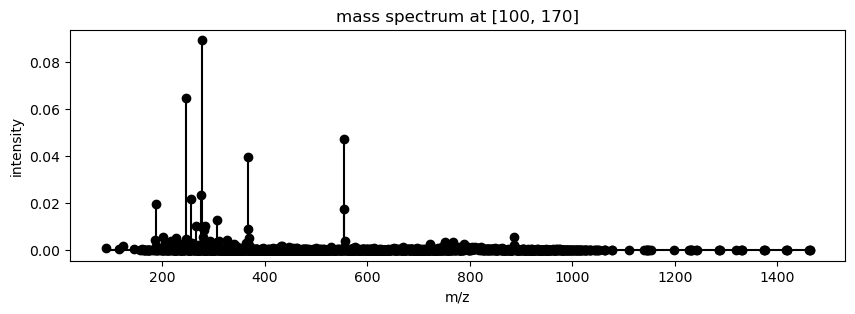

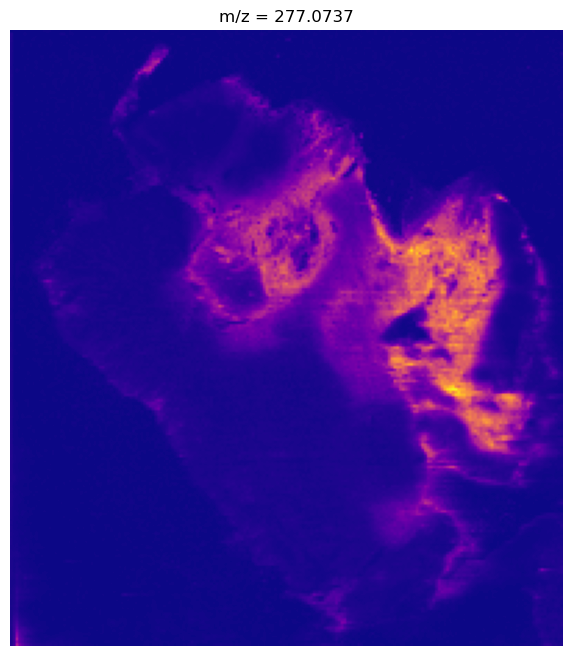

In [5]:

# reshape peaks to 3D (dim_y x dim_x x N_ions)
peaks_image = peaks.reshape((dim_y,dim_x,-1),order='C')
print(peaks_image.shape)

# visualize a spectrum from a specific (x,y) location
ind_y = 100
ind_x = 170
# ind_y = dim_y - 1
# ind_x = dim_x - 1
plt.figure(figsize=(10,3))
plt.stem(mz, peaks_image[ind_y,ind_x,:], linefmt='k', markerfmt='k', basefmt='k')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.title('mass spectrum at '+str([ind_y, ind_x]))
plt.show()

# visualize the peak intensity of a specific ion for all spectra
ind_mz = 234
plt.figure(figsize=(8,8))
plt.imshow( peaks_image[:,:,ind_mz], cmap='plasma')
plt.axis('off')
plt.title('m/z = '+str(mz[ind_mz]))
plt.show()


## univariante combined visualization

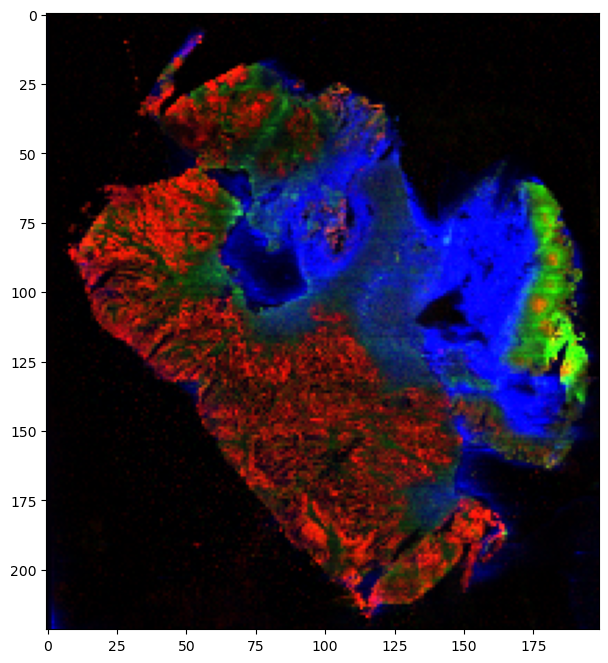

In [6]:
# mz[np.argmin(np.abs(mz-277))]

mz_r = 726.539
mz_g = 766.5359
mz_b = 277.0737

# ch_r = np.argwhere(mz==mz_r)
# ch_g = np.argwhere(mz==mz_g)
# ch_b = np.argwhere(mz==mz_b)

ch_r = np.argmin(np.abs(mz-mz_r))
ch_g = np.argmin(np.abs(mz-mz_g))
ch_b = np.argmin(np.abs(mz-mz_b))

image_r = peaks_norm[:,ch_r].reshape((dim_y,dim_x,-1),order='C')
image_g = peaks_norm[:,ch_g].reshape((dim_y,dim_x,-1),order='C')
image_b = peaks_norm[:,ch_b].reshape((dim_y,dim_x,-1),order='C')
image = np.concatenate([image_r,image_g,image_b], axis=2)

int_scale = 2
plt.figure(figsize=(8,8))
plt.imshow(  np.clip(int_scale*image,0,1) , cmap='gray')
plt.show()

## multivaiant visualization

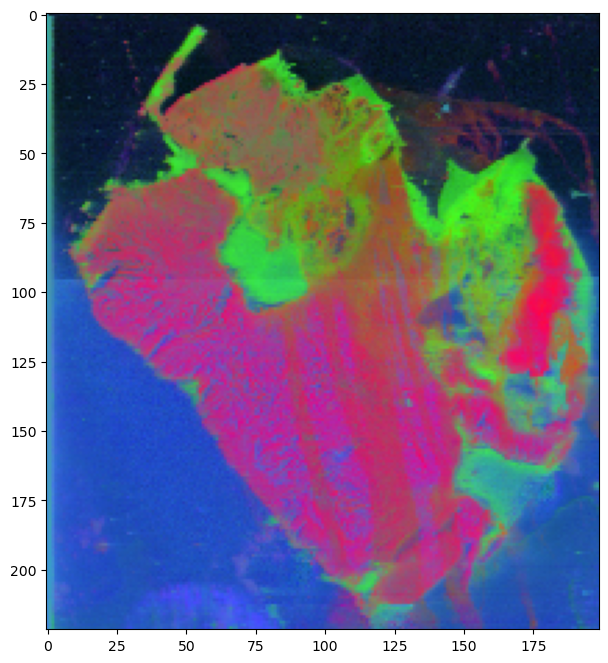

In [14]:
dim_reducion = PCA(n_components=3)

peaks_pca = dim_reducion.fit_transform(peaks_norm)
peaks_pca = ion_minmax_normalize(peaks_pca)
pca_image = peaks_pca.reshape((dim_y,dim_x,-1),order='C')

plt.figure(figsize=(8,8))
plt.imshow(pca_image)
plt.show()

(222, 199)
(222, 199, 2000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


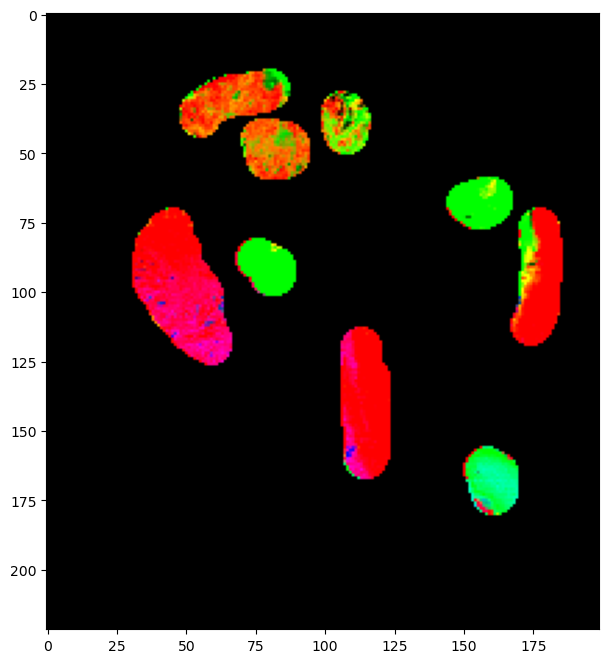

In [8]:
dim_reduction = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)

mask_reshaped = mask_array[:, :, 0].reshape((222, 199, 1))
print(mask_reshaped[:, :, 0].shape) #testing

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

selected_spectra = peaks_image * mask_reshaped #try index instead to select areas

num_rows, num_cols, num_channels = peaks_image.shape

dim_reduction.fit(peaks_norm)

pca_results = np.zeros((num_rows, num_cols, dim_reduction.n_components))  # Initialize the result array

for i in range(num_rows):
    for j in range(num_cols):
        if mask_reshaped[i, j] == 255:
            # Extract the region of interest (ROI) from the MSI data
            roi = peaks_image[i, j, :].reshape(1, -1)  # Reshape to (1, num_channels)

            # Perform PCA on the ROI using the pre-fitted PCA model
            pca_result = dim_reduction.transform(roi)
            pca_result = ion_minmax_normalize(pca_result)

            # Store the PCA results in the corresponding location in the array
            pca_results[i, j, :] = pca_result

plt.figure(figsize=(8,8))
plt.imshow(pca_results)
plt.show()

(222, 199, 2000)


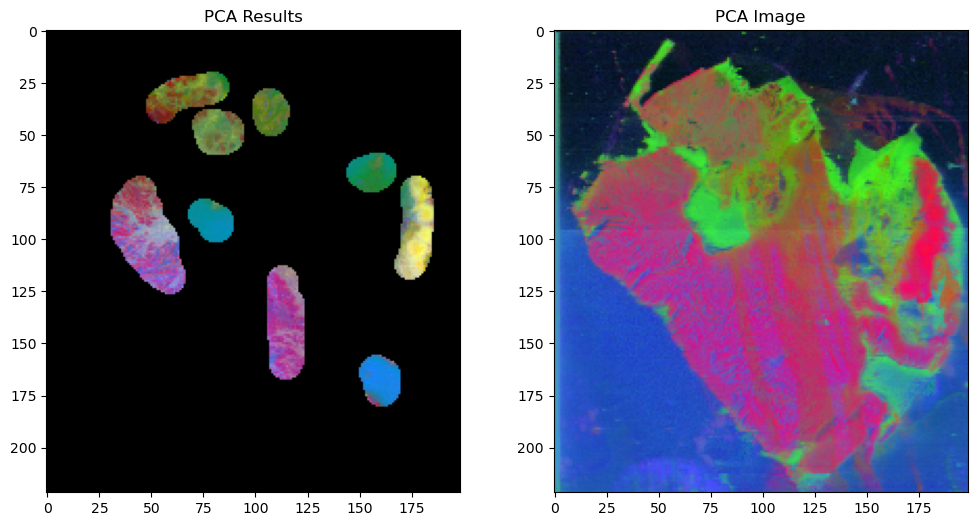

In [15]:
dim_reduction = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

#Get peaks_image shape information
num_rows, num_cols, num_channels = peaks_image.shape


# Step 1: Identify the ROI using the binary mask and create list of ij locations
roi_indices = np.where(mask_array == 255)
roi_pixels = list(zip(roi_indices[0], roi_indices[1]))

# Step 2: Extract spectra from ROI pixels
roi_spectra = []
for i, j in roi_pixels:
    # Extract the spectra for the current ROI pixel (i, j)
    pixel_spectra = peaks_image[i, j]
    roi_spectra.append(pixel_spectra)

# Step 3: convert to np array
roi_spectra_array = np.array(roi_spectra)

# Step 4: Perform PCA

# fit PCA
dim_reduction.fit(roi_spectra_array)

# Perform PCA and normalize
roi_pca = dim_reduction.transform(roi_spectra_array)
roi_pca = ion_minmax_normalize(roi_pca)

# Create empty array and map PCA results from ROI back to the original dimensions (222, 199, 3)
pca_results = np.zeros((num_rows, num_cols, dim_reduction.n_components))
for idx, (i, j) in enumerate(roi_pixels):
    pca_results[i, j, :] = roi_pca[idx]

# # Plot results
# plt.figure(figsize=(8, 8))
# plt.imshow(pca_results)
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pca_results, cmap='viridis')
axes[0].set_title('PCA w/ Mask')

axes[1].imshow(pca_image, cmap='viridis')
axes[1].set_title('PCA Original')

plt.show()


(222, 199)
(222, 199, 2000)
(222, 199, 2000)
(44178, 2000)
(44178, 3)
(222, 199, 3)


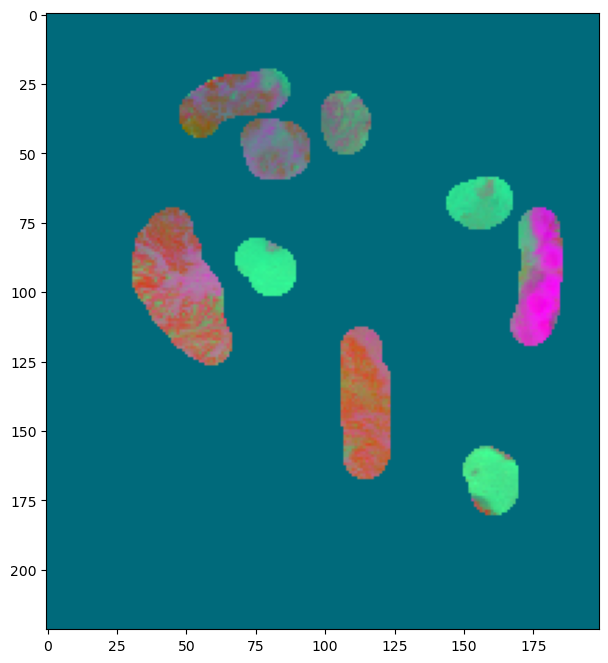

In [10]:
dim_reducion = PCA(n_components=3)

mask = sitk.ReadImage(r"C:\Users\jenni\OneDrive\Documents\DESI-Sampledata\2021 03 21 colon 0485699_mask.png")
mask_array = sitk.GetArrayFromImage(mask)


mask_reshaped = mask_array[:, :, 0].reshape((222, 199, 1))
print(mask_array[:, :, 0].shape)

peaks_image = peaks_norm.reshape((dim_y,dim_x,-1),order='C') #reshape peaks_norm to (222, 199, 2000)
print(peaks_image.shape) #testing

selected_spectra = peaks_image * mask_reshaped #try index instead to select areas

print(selected_spectra.shape)
#try making a for loop to select pixels that are part of the mask and not, append the ij location of them. New array with PCA results
selected_spectra_image = selected_spectra.reshape(dim_y*dim_x, -1) #Reshape image back to 2D array dim_y*dim_x, -1
print(selected_spectra_image.shape) #testing

peaks_pca = dim_reducion.fit_transform(selected_spectra_image)
peaks_pca = ion_minmax_normalize(peaks_pca)

print(peaks_pca.shape)
pca_image = peaks_pca.reshape((222,199,-1),order='C')
print(pca_image.shape)

plt.figure(figsize=(8,8))
plt.imshow(pca_image)
plt.show()